In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import scipy.signal as ss
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from simulate_triple import simulate
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from tools_plot import despine, set_style
import pandas as pd
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

from causal_optoconnectics.core import find_response_spikes
from causal_optoconnectics.buzsaki import transfer_probability

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

In [4]:
colors = ['#1b9e77', '#d95f02', '#7570b3']

In [5]:
# J_ACs = np.arange(0, 7.1, .1)
# simulations_J_AC = defaultdict(list)
# for a in tqdm(J_ACs):
#     data = simulate(stop_time=4000, J_AC=a, ac_amp=1., ac_offset=-.5, pbar=lambda x:x)
#     stop_time = data['status']['time']
#     spiketrains = data['spiketrains'].groupby('senders')
#     A_spikes = spiketrains.get_group(1)['times'].to_numpy()
#     B_spikes = spiketrains.get_group(2)['times'].to_numpy()
#     C_spikes = spiketrains.get_group(3)['times'].to_numpy()
    
#     simulations_J_AC['stim_times'].append(data['stim_times'])
#     simulations_J_AC['A_spikes'].append(A_spikes)
#     simulations_J_AC['B_spikes'].append(B_spikes)
#     simulations_J_AC['C_spikes'].append(C_spikes)
#     simulations_J_AC['stop_time'].append(stop_time)
#     simulations_J_AC['J_AC'].append(a)

# np.savez('simulations_J_AC_osc.npz', data=simulations_J_AC)
simulations = np.load('../simulations_J_AC_osc.npz', allow_pickle=True)['data'][()]

In [6]:
x1 = 1
x2 = 3
y1 = 3
y2 = 10
z1 = 2
z2 = 0
dt = 15

d = y2 - y1

In [159]:
simulations = simulations
amps = simulations['J_AC']

spikes = defaultdict(list)
for i, a in enumerate(tqdm(amps)):

    S_times = simulations['stim_times'][i]
    A_spikes = simulations['A_spikes'][i]
    B_spikes = simulations['B_spikes'][i]
    C_spikes = simulations['C_spikes'][i]
    stop_time = simulations['stop_time'][i]
    
    X_A, Z_A, X_B, Z_B = [], [], [], []
    Y_0, Y = [], []
    for t in S_times:
        # searchsorted:
        # left	a[i-1] < v <= a[i]
        # right	a[i-1] <= v < a[i]
        # t - dz < z <= t
        idx = np.searchsorted(A_spikes, [t - z1, t - z2], side='right')
        Z_A.append(np.diff(idx) > 0)
        # t < x <= t + dt
        idx = np.searchsorted(A_spikes, [t + x1, t + x2], side='right')
        X_A.append(np.diff(idx) > 0)
        
        idx = np.searchsorted(B_spikes, [t - z1, t - z2], side='right')
        Z_B.append(np.diff(idx) > 0)
        # t < x <= t + dt
        idx = np.searchsorted(B_spikes, [t + x1, t + x2], side='right')
        X_B.append(np.diff(idx) > 0)
        # t < y <= t + dt
        idx = np.searchsorted(C_spikes, [t + y1, t + y2], side='right')
        Y.append(np.diff(idx) > 0)
        
        idx = np.searchsorted(C_spikes, [t + dt - d, t + dt], side='right')
        Y_0.append(np.diff(idx) > 0)
        
    Z_A = np.array(Z_A, dtype=bool).ravel()
    Z_B = np.array(Z_B, dtype=bool).ravel()
    X_A = np.array(X_A, dtype=bool).ravel()
    X_B = np.array(X_B, dtype=bool).ravel()
    Y = np.array(Y, dtype=bool).ravel()
    Y_0 = np.array(Y_0, dtype=bool).ravel()
    
    spikes['Z_A'].append(Z_A)
    spikes['X_A'].append(X_A)
    
    spikes['Z_B'].append(Z_B)
    spikes['X_B'].append(X_B)
    
    spikes['Y'].append(Y)
    spikes['Y_0'].append(Y_0)

pynest:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [100]:
trans_prob_params = {
    'y_mu': 2,
    'y_sigma': 1.2,
    'bin_size': 1,
    'limit': 15,
    'hollow_fraction': .6,
    'width': 60
}

buszaki = defaultdict(list)
for i, a in enumerate(tqdm(amps)):

    S_times = simulations['stim_times'][i]
    A_spikes = simulations['A_spikes'][i]
    B_spikes = simulations['B_spikes'][i]
    C_spikes = simulations['C_spikes'][i]
    stop_time = simulations['stop_time'][i]
    
    tr_AC = transfer_probability(A_spikes, C_spikes, **trans_prob_params)[0]
    tr_BC = transfer_probability(B_spikes, C_spikes, **trans_prob_params)[0]

    buszaki['tr_AC'].append(tr_AC)
    buszaki['tr_BC'].append(tr_BC)

pynest:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [174]:
results = defaultdict(list)
for i, a in enumerate(tqdm(amps)):

    Z_A = spikes['Z_A'][i]
    X_A = spikes['X_A'][i]
    Y = spikes['Y'][i]
    Y_0 = spikes['Y_0'][i]
    
    Z_B = spikes['Z_B'][i]
    X_B = spikes['X_B'][i]
    ZA0 = (X_A==1) & (Z_A==0)
    ZA1 = (X_A==0) & (Z_A==1)
    ZB0 = (X_B==1) & (Z_B==0)
    ZB1 = (X_B==0) & (Z_B==1)
    beta_AC = Y[ZA0].mean() - Y[ZA1].mean() + Y_0[ZA0].mean() - Y_0[ZA1].mean()
    beta_BC = Y[ZB0].mean() - Y[ZB1].mean() + Y_0[ZB0].mean() - Y_0[ZB1].mean()
#     print(X_A[Z_A==1].mean(), X_A[Z_A==0].mean())
#     beta_AC = (Y[Z_A==1].mean() - Y[Z_A==0].mean()) / (X_A[Z_A==1].mean() - X_A[Z_A==0].mean())
#     beta_BC = (Y[Z_B==1].mean() - Y[Z_B==0].mean()) / (X_B[Z_B==1].mean() - X_B[Z_B==0].mean())
    
    results['beta_AC'].append(beta_AC)
    results['beta_BC'].append(beta_BC)
    
    cond_AC = Y[X_A==1].mean() - Y[X_A==0].mean() - Y_0[X_A==1].mean() + Y_0[X_A==0].mean()
    cond_BC = Y[X_B==1].mean() - Y[X_B==0].mean() - Y_0[X_B==1].mean() + Y_0[X_B==0].mean()
    
    results['cond_AC'].append(cond_AC)
    results['cond_BC'].append(cond_BC)
    
    results['tr_AC'].append(buszaki['tr_AC'][i])
    results['tr_BC'].append(buszaki['tr_BC'][i])
    
results = pd.DataFrame(results)

pynest:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


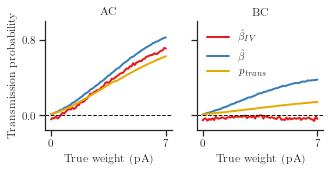

In [177]:
# set_style(h=1, style='notebook')
set_style(h=1, style='article')

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
axba, axbb = axs.flatten()

axba.plot(amps, results['beta_AC'], color='#e41a1c')

axbb.plot(amps, results['beta_BC'], color='#e41a1c', label=r'$\hat{\beta}_{IV}$')

axba.plot(amps, results['cond_AC'], color='#377eb8')
axbb.plot(amps, results['cond_BC'], color='#377eb8', label=r'$\hat{\beta}$')

tr_AC = results['tr_AC']# / (results['cond_AC'].max() - results['tr_AC'].max())
tr_BC = results['tr_BC']# / (results['cond_AC'].max() - results['tr_AC'].max())

axba.plot(amps, tr_AC, color='#e6ab02')
axbb.plot(amps, tr_BC, color='#e6ab02', label=r'$p_{trans}$')

axba.axhline(0, color='k', lw=1, ls='--')
axbb.axhline(0, color='k', lw=1, ls='--')

axba.set_ylabel('Transmission probability')
axba.set_xlabel('True weight (pA)')
axbb.set_xlabel('True weight (pA)')
axba.set_title('AC')
axbb.set_title('BC')
despine()
axba.set_xticks([0,7])
axbb.set_yticks([0,round(max(results['cond_AC']),1)])
axbb.set_ylim([-.15,round(max(results['cond_AC']))])

axbb.legend(frameon=False)
fig.savefig('../manuscript/figures/triple-estimate.svg')

# Single trial

In [19]:
i = 70

S = simulations['stim_times'][i]
A = simulations['A_spikes'][i]
B = simulations['B_spikes'][i]
C = simulations['C_spikes'][i]
stop_time = simulations['stop_time'][i]
print(simulations['J_AC'][i])

7.0


In [20]:
Z_A, X_A, Y_A = find_response_spikes(A, C, S, dt=30, z1=2, z2=0)
Z_B, X_B, Y_B = find_response_spikes(B, C, S, dt=30, z1=2, z2=0)

In [21]:
X_AA = np.array([any((t >= x1) & (t <= x2)) for t in X_A])
Y_AA = np.array([any((t >= y1) & (t <= y2)) for t in Y_A])

In [22]:
wald = (Y_AA[Z_A==1].mean() - Y_AA[Z_A==0].mean()) / (X_AA[Z_A==1].mean() - X_AA[Z_A==0].mean())
beta_iv = Y_AA[X_AA==1].mean() - Y_AA[Z_A==1].mean()

In [23]:
from linearmodels import IVLIML

In [24]:
IVLIML(dependent=Y_AA, exog=np.ones_like(X_AA), endog=X_AA, instruments=Z_A).fit(cov_type='unadjusted')

IV-LIML Estimation Summary                          
==============================================================================
Dep. Variable:              dependent   R-squared:                      0.4864
Estimator:                    IV-LIML   Adj. R-squared:                 0.4864
No. Observations:              158008   F-statistic:                    434.70
Date:                Fri, Nov 15 2019   P-value (F-stat)                0.0000
Time:                        09:55:27   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog           0.1750     0.0063     27.904     0.0000      0.1628      0.1873
endog          0.4261     0.0204     20.849     0.0000      0.3860      0.4662
==============================================================================

Endogenous: endog
Instruments: instruments
Unadjusted Covariance (Homoskedastic)
Debiased: False
Kappa: 1.000
IVResults, id: 0x7f8b009c9a20

In [25]:
wald, beta_iv

(0.42610260808739636, 0.6752896924053416)

In [164]:
sum(Z_A), sum(Z_B)

(2763, 2710)

In [165]:
len(S)

157933

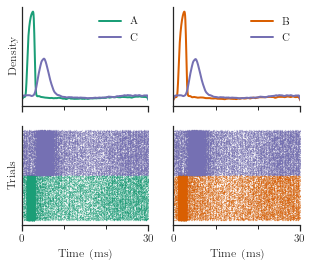

In [58]:
set_style(h=2, style='article')

fig, axs = plt.subplots(2, 2, sharex=True)

sigma = .02
s = 0.01

spike_trials = [t for trial in X_A for t in trial]
spike_ids = [t for i, trial in enumerate(X_A) for t in [i]*len(trial)]

pd.Series(spike_trials).plot.kde(ax=axs[0,0], bw_method=sigma, color=colors[0], label='A')
axs[1,0].scatter(spike_trials, spike_ids, s=s, color=colors[0])

spike_trials = [t for trial in Y_A for t in trial]
spike_ids = [t for i, trial in enumerate(Y_A) for t in [i+len(X_A)]*len(trial)]

pd.Series(spike_trials).plot.kde(ax=axs[0,0], bw_method=sigma, color=colors[2], label='C')
axs[1,0].scatter(spike_trials, spike_ids, s=s, color=colors[2])
# B 


spike_trials = [t for trial in X_B for t in trial]
spike_ids = [t for i, trial in enumerate(X_B) for t in [i]*len(trial)]

pd.Series(spike_trials).plot.kde(ax=axs[0,1], bw_method=sigma, color=colors[1], label='B')
axs[1,1].scatter(spike_trials, spike_ids, s=s, color=colors[1])

spike_trials = [t for trial in Y_B for t in trial]
spike_ids = [t for i, trial in enumerate(Y_B) for t in [i+len(X_A)]*len(trial)]

pd.Series(spike_trials).plot.kde(ax=axs[0,1], bw_method=sigma, color=colors[2], label='C')
axs[1,1].scatter(spike_trials, spike_ids, s=s, color=colors[2])


axs[0,0].set_xticks([0,30])
axs[1,0].set_xlabel('Time (ms)')
axs[1,1].set_xlabel('Time (ms)')
axs[0,1].set_ylabel('')
axs[1,0].set_ylabel('Trials')
despine(yticks=False)
plt.xlim(0,30)
axs[0,0].legend()
axs[0,1].legend()
fig.savefig('../manuscript/figures/triple-response.png', dpi=300)

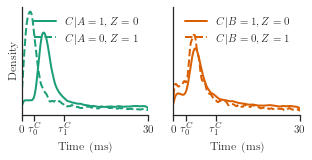

In [171]:
set_style(h=1, style='article')
# set_style(h=1, style='notebook')
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

sigma = .05

X_AA = np.array([any((t >= x1) & (t <= x2)) for t in X_A])

Y_A_X = Y_A[X_AA==1]
# Y_A_X = Y_A[Z_A==0]
# Y_A_X = np.random.choice(Y_A_X, sum(Z_A))

spike_trials = [t for trial in Y_A_X for t in trial]

pd.Series(spike_trials).plot.kde(ax=axs[0], bw_method=sigma, color=colors[0], label='$C|A=1,Z=0$')

spike_trials = [t for trial in Y_A[Z_A==1] for t in trial]

pd.Series(spike_trials).plot.kde(ax=axs[0], bw_method=sigma, color=colors[0], ls='--', label='$C|A=0,Z=1$')


# B 

X_BB = np.array([any((t >= x1) & (t <= x2)) for t in X_B])

Y_B_X = Y_B[X_BB==1]
# Y_B_X = Y_B[Z_B==0]
# Y_B_X = np.random.choice(Y_B_X, sum(Z_B))

spike_trials = [t for trial in Y_B_X for t in trial]

pd.Series(spike_trials).plot.kde(ax=axs[1], bw_method=sigma, color=colors[1], label='$C|B=1,Z=0$')

spike_trials = [t for trial in Y_B[Z_B==1] for t in trial]

pd.Series(spike_trials).plot.kde(ax=axs[1], bw_method=sigma, color=colors[1], ls='--', label='$C|B=0,Z=1$')


axs[0].set_xticks([0,3,10,30])
axs[0].set_xticklabels([0, r'$\tau_0^C$', r'$\tau_1^C$', 30])
axs[0].set_xlabel('Time (ms)')
axs[1].set_xlabel('Time (ms)')
# axs[0,1].set_ylabel('')
# axs[1,0].set_ylabel('Trials')
despine(yticks=False)
plt.xlim(0,30)
axs[0].legend()
axs[1].legend()
fig.savefig('../manuscript/figures/triple-instrument.svg')

# single run

In [30]:
data = simulate(stop_time=600, record_state=True, ac_amp=1., ac_offset=-.5, pbar=tqdm)

HBox(children=(IntProgress(value=0, max=9508), HTML(value='')))

In [31]:
state = data['state'].groupby('senders')
spiketrains = data['spiketrains'].groupby('senders')

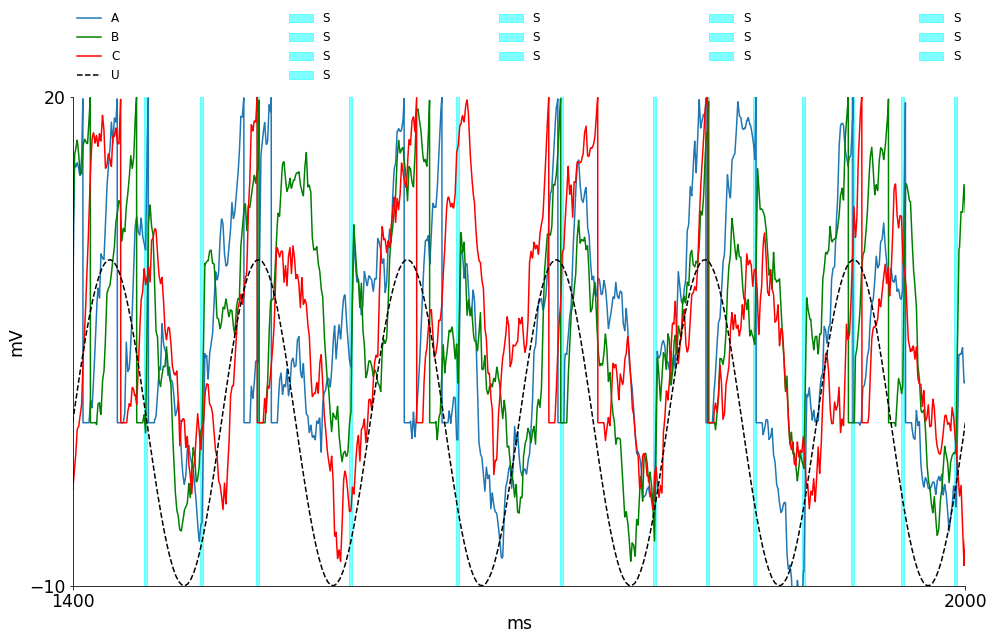

In [32]:
plt.figure(figsize=(16,9))
xlim = [1400, 2000]
ylim = [-10, 20]
mask_s = (data['stim_times'] > xlim[0]) & (data['stim_times'] < xlim[1])
plt.plot(state.get_group(1).times, state.get_group(1).V_m, label='A')
plt.plot(state.get_group(2).times, state.get_group(2).V_m, 'g', label='B')
plt.plot(state.get_group(3).times, state.get_group(3).V_m, 'r', label='C')
for s in data['stim_times'][mask_s]:
    plt.axvspan(s, s+2, alpha=.5, color='cyan', label='S')
    
t = np.linspace(0, xlim[-1], 1000)
ac = 10 * np.sin(2 * np.pi * data['params']['ac_freq'] * t)
plt.plot(t, ac, '--k', label='U')
plt.xlim(xlim)
plt.xlabel('ms')
plt.ylabel('mV')

plt.ylim(ylim)
plt.legend(
    frameon=False,
    bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    mode="expand", borderaxespad=0, ncol=5, fontsize='large')

plt.gca().set_yticks(ylim)
plt.gca().set_xticks(xlim)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

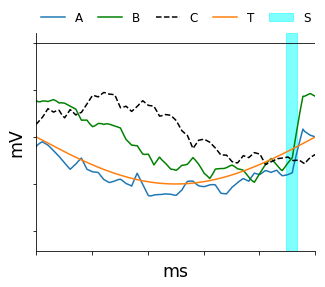

In [33]:
plt.figure(figsize=(5,4))
xlim = [950, 1000]
mask_s = (data['stim_times'] > xlim[0]) & (data['stim_times'] < xlim[1])
plt.plot(state.get_group(1).times, state.get_group(1).V_m, label='A')
plt.plot(state.get_group(2).times, state.get_group(2).V_m, 'g', label='B')
plt.plot(state.get_group(3).times, state.get_group(3).V_m, '--k', label='C')
for s in data['stim_times'][mask_s]:
    plt.axvspan(s, s+2, alpha=.5, color='cyan', label='S')
    
t = np.linspace(0, 1000, 1000)
ac = 10 * np.sin(2 * np.pi * data['params']['ac_freq'] * t)
plt.plot(t, ac, label='T')
plt.xlim(xlim)
plt.xlabel('ms')
plt.ylabel('mV')
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.ylim(-5, 20)
plt.legend(
    frameon=False,
    bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    mode="expand", borderaxespad=0, ncol=5, fontsize='large')
plt.axhline(20, color='k', lw=.8)